<a href="https://colab.research.google.com/github/PremKumar-V/NLP_Projects/blob/main/Disaster_Tweets_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Disaster Tweets Classification

### Reference
- [Dataset Link](https://www.kaggle.com/competitions/nlp-getting-started/data)


## Prepare Notebook


In [1]:
# Install Necessary Dependencies

%%bash

pip install torchviz torchmetrics kaggle --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 21.7 MB/s eta 0:00:00


In [2]:
# Download Dataset

%%bash
mkdir ~/.kaggle
cp kaggle.json ~/.kaggle/kaggle.json
chmod 600 ~/.kaggle/kaggle.json

kaggle competitions download -c nlp-getting-started
unzip nlp-getting-started.zip -d data


Archive:  nlp-getting-started.zip
  inflating: data/sample_submission.csv  
  inflating: data/test.csv           
  inflating: data/train.csv          


100%|██████████| 593k/593k [00:00<00:00, 68.7MB/s]


In [3]:
# Import Packages

import re
import string
import numpy as np
import pandas as pd
from tqdm import trange

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import nltk
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, porter, snowball
from nltk.probability import FreqDist
from collections import Counter

from sklearn.feature_extraction import text

import warnings
warnings.filterwarnings('ignore')

nltk.download('omw-1.4', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (17,7)
plt.rcParams['font.size'] = 18

In [4]:
# Load Dataset

trainFileName = '/content/data/train.csv'
testFileName = '/content/data/test.csv'
subFileName = '/content/data/sample_submission.csv'

In [5]:
trainDf = pd.read_csv(trainFileName)
testDf = pd.read_csv(testFileName)
subDf = pd.read_csv(subFileName)

## EDA

In [6]:
trainDf.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
testDf.head(5)

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [8]:
trainDf = trainDf[['text', 'target']]
testDf = testDf[['text']]

In [9]:
trainDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    7613 non-null   object
 1   target  7613 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 119.1+ KB


In [10]:
trainDf.target.value_counts(normalize = True)

0    0.57034
1    0.42966
Name: target, dtype: float64

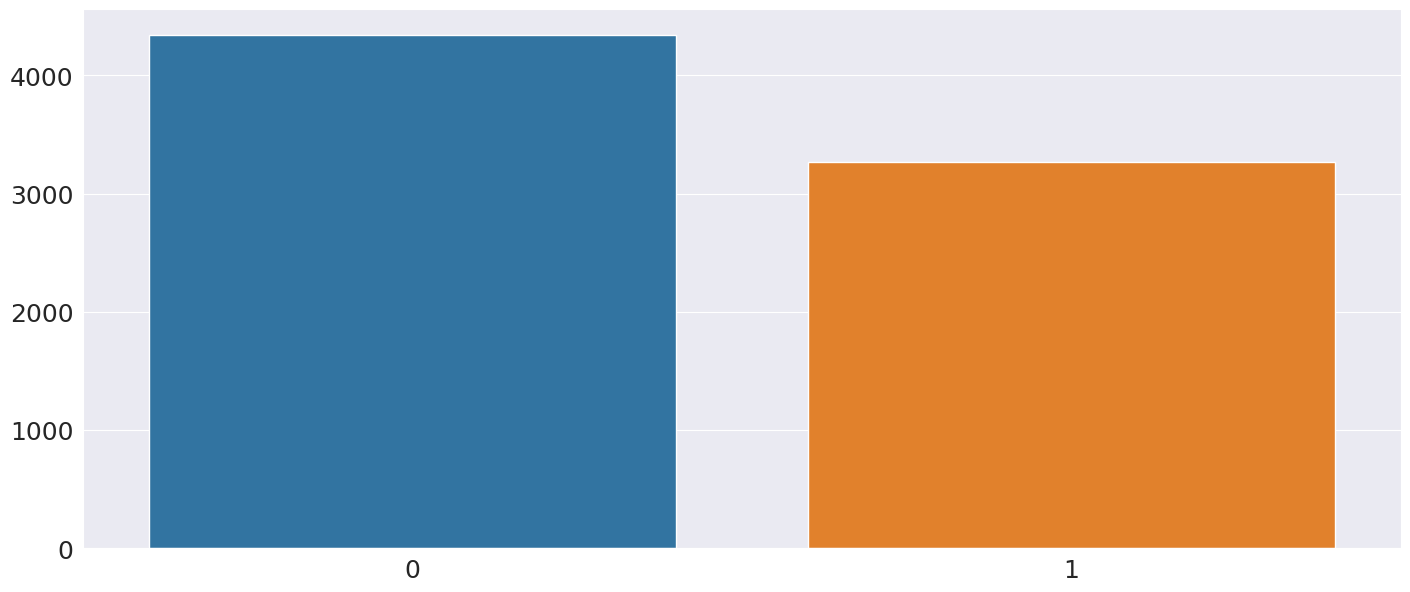

In [11]:
targetValueCounts = trainDf.target.value_counts()
sns.barplot(x = targetValueCounts.index, y = targetValueCounts.values);

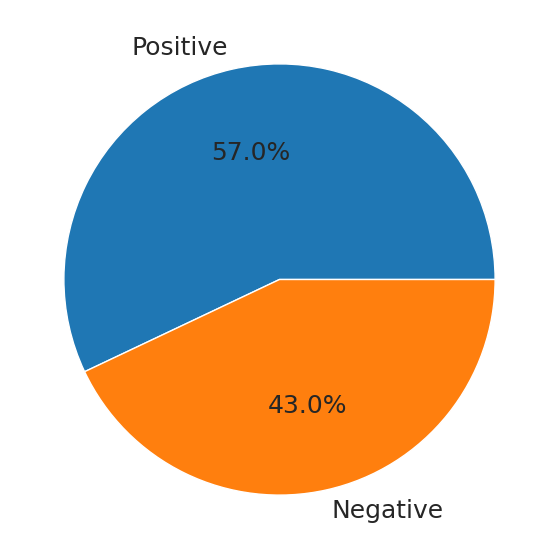

In [12]:
plt.pie(targetValueCounts, autopct='%1.1f%%', labels=['Positive', 'Negative']);

In [13]:
# Term Ferquency Analysis

def clean(text):
    text = text.lower()
    text = re.sub('[^a-z A-Z 0-9-]+', '', text)
    text = " ".join([word for word in text.split() if word not in stopwords.words('english')])

    return text

In [14]:
trainDf['text_'] = trainDf['text'].apply(clean)

In [15]:
trainDf['text_'][0]

'deeds reason earthquake may allah forgive us'

In [16]:
def corpus(text):
    corpus = text.split()
    return corpus

In [17]:
corpus(trainDf['text'][0])

['Our',
 'Deeds',
 'are',
 'the',
 'Reason',
 'of',
 'this',
 '#earthquake',
 'May',
 'ALLAH',
 'Forgive',
 'us',
 'all']

In [18]:
trainDf['text_array'] = trainDf['text_'].apply(corpus)

In [19]:
trainDf['text_array'][0]

['deeds', 'reason', 'earthquake', 'may', 'allah', 'forgive', 'us']

In [20]:
corpus_data = []

for i in trange(trainDf.shape[0], ncols=150, nrows=10, colour='green', smoothing=0.8):
    corpus_data += trainDf['text_array'][i]
len(corpus_data)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 7613/7613 [00:00<00:00, 122473.76it/s]


76485

In [21]:
most_common = Counter(corpus_data).most_common(10)
most_common

[('-', 778),
 ('like', 344),
 ('im', 302),
 ('amp', 298),
 ('fire', 249),
 ('get', 228),
 ('new', 226),
 ('via', 220),
 ('dont', 206),
 ('people', 196)]

In [22]:
words, freqs = [], []

for word, freq in most_common:
    words.append(word)
    freqs.append(freq)


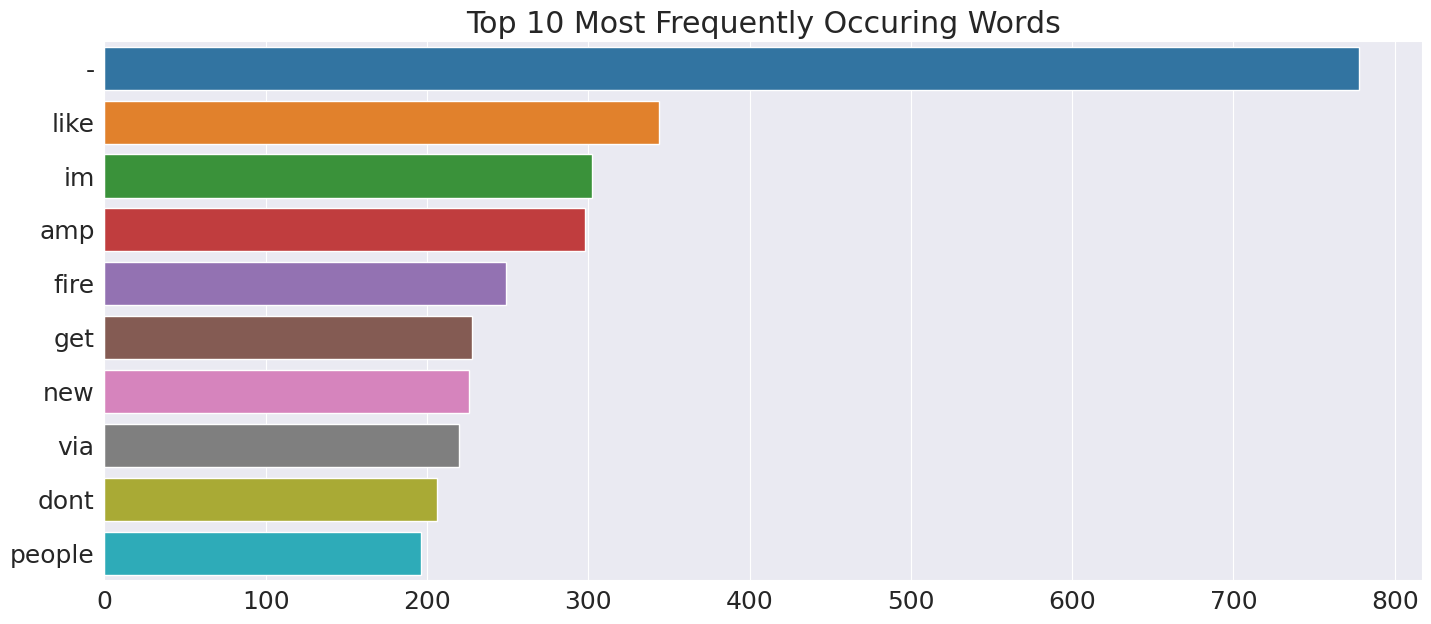

In [23]:
sns.barplot(x=freqs, y=words)
plt.title('Top 10 Most Frequently Occuring Words')
plt.show()

In [26]:
def n_grams(ngrams):
    cv = text.CountVectorizer(ngram_range = ngrams)
    grams = cv.fit_transform(trainDf['text'])
    count_values = grams.toarray().sum(axis=0)
    ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv.vocabulary_.items()], reverse = True))
    ngram_freq.columns = ["frequency", "ngram"]

    sns.barplot(x=ngram_freq['frequency'][:10], y=ngram_freq['ngram'][:10])
    plt.title(f'Top 10 Most Frequently Occuring {ngrams[0]}-grams')
    plt.show()

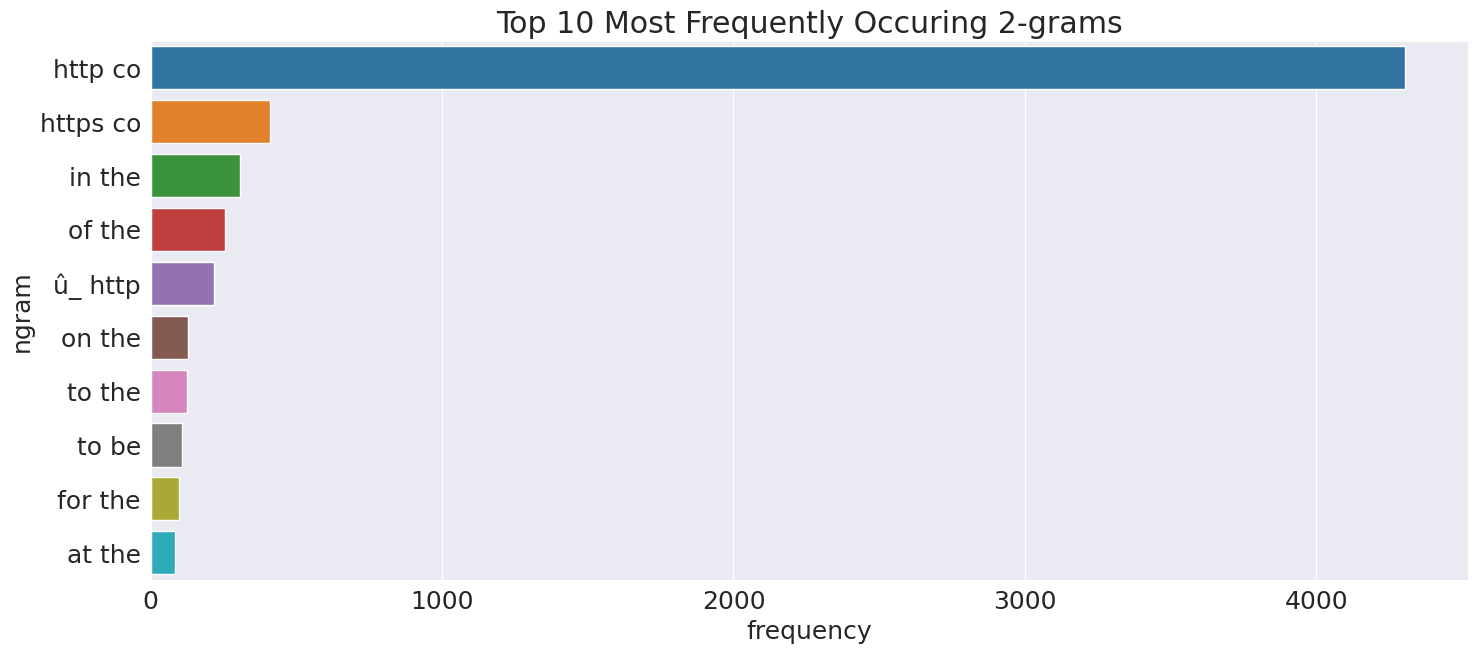

In [27]:
n_grams((2, 2))

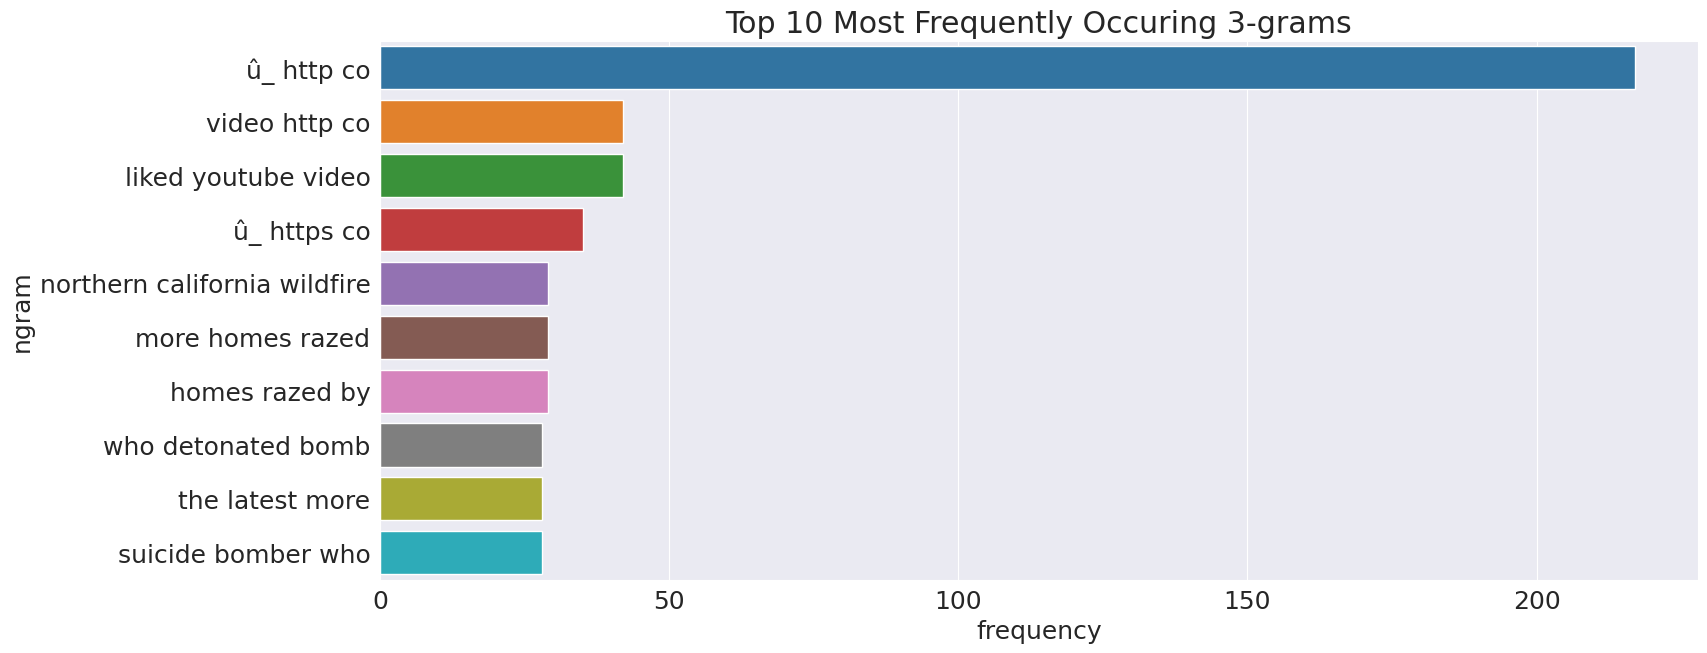

In [28]:
n_grams((3, 3))

In [29]:
trainDf = trainDf[['text', 'target']]

## Modelling

In [30]:
tokenizer1 = nltk.tokenize.WhitespaceTokenizer()
tokenizer2 = nltk.tokenize.TreebankWordTokenizer()
tokenizer3 = nltk.tokenize.WordPunctTokenizer()
tokenizer4 = nltk.tokenize.RegexpTokenizer(r'\w+')

In [31]:
sample_text = trainDf.text[555]
sample_text

'Kelby Tomlinson mild-mannered 2nd baseman for a great metropolitan team fights a never-ending battle for hits RBI and the #SFGiants way.'

In [32]:
for tokenizer in [tokenizer1, tokenizer2, tokenizer3, tokenizer4]:
    tokens = tokenizer.tokenize(sample_text)
    print(f"{tokenizer.__class__.__name__} -- {tokens}")

WhitespaceTokenizer -- ['Kelby', 'Tomlinson', 'mild-mannered', '2nd', 'baseman', 'for', 'a', 'great', 'metropolitan', 'team', 'fights', 'a', 'never-ending', 'battle', 'for', 'hits', 'RBI', 'and', 'the', '#SFGiants', 'way.']
TreebankWordTokenizer -- ['Kelby', 'Tomlinson', 'mild-mannered', '2nd', 'baseman', 'for', 'a', 'great', 'metropolitan', 'team', 'fights', 'a', 'never-ending', 'battle', 'for', 'hits', 'RBI', 'and', 'the', '#', 'SFGiants', 'way', '.']
WordPunctTokenizer -- ['Kelby', 'Tomlinson', 'mild', '-', 'mannered', '2nd', 'baseman', 'for', 'a', 'great', 'metropolitan', 'team', 'fights', 'a', 'never', '-', 'ending', 'battle', 'for', 'hits', 'RBI', 'and', 'the', '#', 'SFGiants', 'way', '.']
RegexpTokenizer -- ['Kelby', 'Tomlinson', 'mild', 'mannered', '2nd', 'baseman', 'for', 'a', 'great', 'metropolitan', 'team', 'fights', 'a', 'never', 'ending', 'battle', 'for', 'hits', 'RBI', 'and', 'the', 'SFGiants', 'way']


In [37]:
eng_stopwords = stopwords.words('english')

regTokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
snowballStemmer = snowball.SnowballStemmer(language = 'english')

In [93]:
class ModelPreprocess:
    def __init__(self, stemmer, tokenizer, vectorizer):
        self.stemmer = stemmer
        self.tokenizer = tokenizer
        self.vectorizer = vectorizer

    def preprocess(self):
        vectorizer.fit(trainDf.text)

        trainInputs = vectorizer.transform(trainDf.text)
        trainTargets = trainDf.target
        testInputs = vectorizer.transform(testDf.text)

        vocab = vectorizer.vocabulary_

        return (trainInputs, trainTargets, testInputs, vocab)

In [63]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [64]:
vectorizer = TfidfVectorizer(
                tokenizer = tokenize,
                stop_words = eng_stopwords,
                ngram_range = (1, 1),
                max_features = 2000
)

In [65]:
model1 = ModelPreprocess(snowballStemmer.stem, nltk.tokenize.RegexpTokenizer(r'\w+').tokenize, vectorizer)
trainInputs, trainTargets, testInputs, vocab = model1.preprocess()

In [90]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


def train(trainInputs, trainTargets):

    rfc = RandomForestClassifier(n_estimators = 100, n_jobs = -1, random_state = 4, max_depth = 100)
    rfc.fit(trainInputs, trainTargets)
    trainPreds = rfc.predict(trainInputs)

    print(accuracy_score(trainPreds, trainTargets))


    sns.heatmap(confusion_matrix(trainPreds, trainTargets), annot = True, fmt=".1f")
    plt.show()

    print(classification_report(trainTargets, trainPreds, target_names=['0', '1']))

0.927755155654801


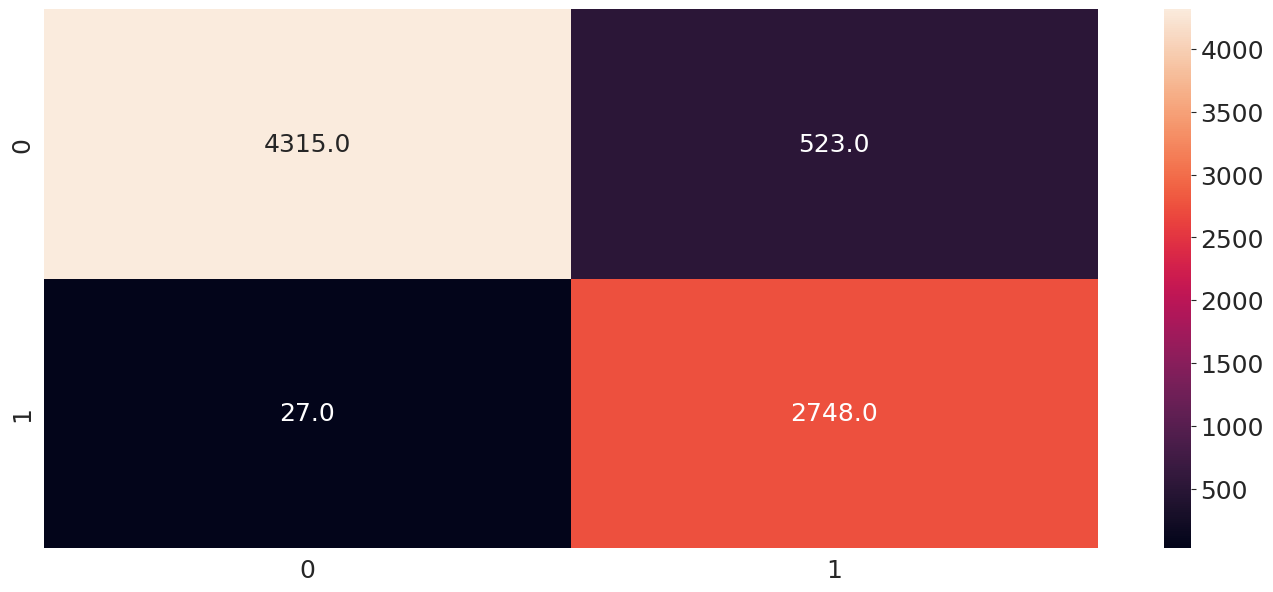

              precision    recall  f1-score   support

           0       0.89      0.99      0.94      4342
           1       0.99      0.84      0.91      3271

    accuracy                           0.93      7613
   macro avg       0.94      0.92      0.92      7613
weighted avg       0.93      0.93      0.93      7613



In [91]:
train(trainInputs, trainTargets)

0.927755155654801


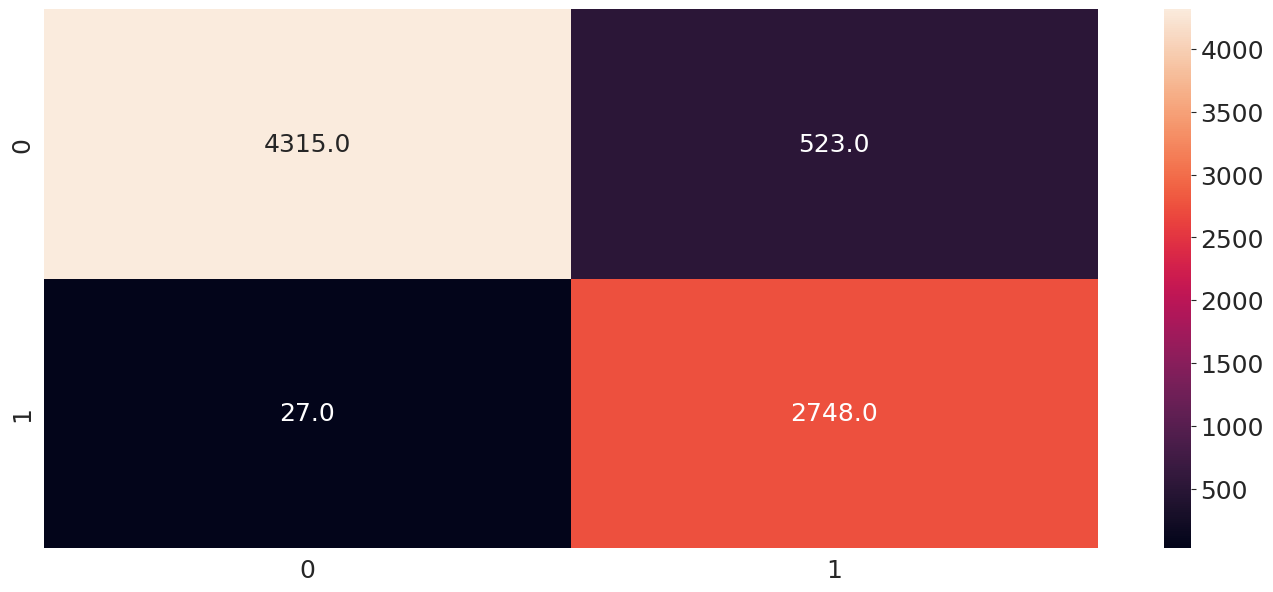

              precision    recall  f1-score   support

           0       0.89      0.99      0.94      4342
           1       0.99      0.84      0.91      3271

    accuracy                           0.93      7613
   macro avg       0.94      0.92      0.92      7613
weighted avg       0.93      0.93      0.93      7613



In [92]:
model2 = ModelPreprocess(snowballStemmer.stem, nltk.tokenize.TreebankWordTokenizer().tokenize, vectorizer)
trainInputs, trainTargets, testInputs, vocab = model2.preprocess()

train(trainInputs, trainTargets)